In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import os

In [2]:
img_left = cv2.imread("C:\\Users\\Darshan\\Downloads\\Computer Vision\\left01.jpg", cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread("C:\\Users\\Darshan\\Downloads\\Computer Vision\\right01.jpg", cv2.IMREAD_GRAYSCALE)

In [3]:
pattern_size = (9, 6)  # 9x6 inner corners
square_size = 1.0      # Arbitrary units

In [4]:
# 3D object points (known chessboard geometry)
objp = np.zeros((np.prod(pattern_size), 3), np.float32)
objp[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
objp *= square_size

In [5]:
ret1, corners1 = cv2.findChessboardCorners(img_left, pattern_size)
ret2, corners2 = cv2.findChessboardCorners(img_right, pattern_size)

In [6]:
if not (ret1 and ret2):
    raise RuntimeError("Chessboard corners not found in one or both images.")

In [7]:
# Refine corner locations
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
corners1 = cv2.cornerSubPix(img_left, corners1, (11,11), (-1,-1), criteria)
corners2 = cv2.cornerSubPix(img_right, corners2, (11,11), (-1,-1), criteria)

In [8]:
# Step 5: Assume simple pinhole intrinsics
h, w = img_left.shape
f = 800  # Approximate focal length in pixels
K = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]])

In [9]:
# Step 6: Estimate Essential Matrix and pose
E, mask = cv2.findEssentialMat(corners1, corners2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
_, R, t, mask_pose = cv2.recoverPose(E, corners1, corners2, K)

In [10]:
# Projection matrices
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((R, t))

In [11]:
# Step 7: Triangulate 3D points
pts4d = cv2.triangulatePoints(P1, P2, corners1.squeeze().T, corners2.squeeze().T)
pts3d = (pts4d[:3] / pts4d[3]).T

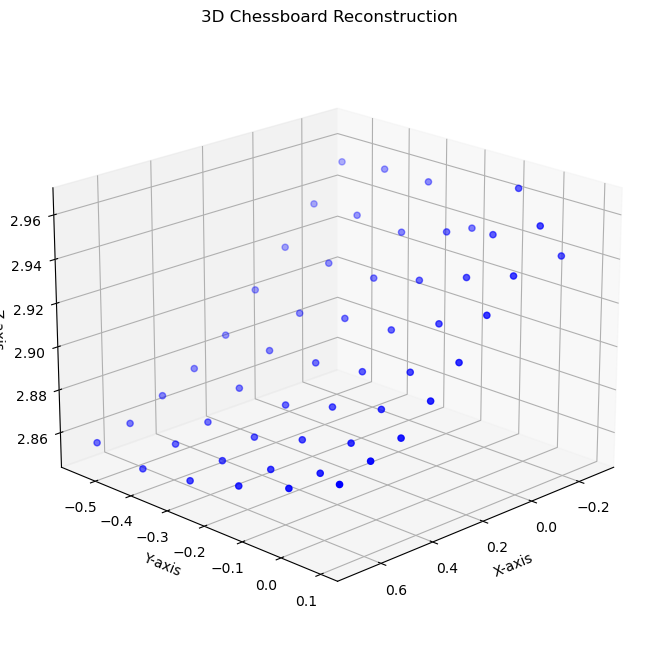

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts3d[:, 0], pts3d[:, 1], pts3d[:, 2], c='b', s=20)
ax.set_title("3D Chessboard Reconstruction")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.view_init(elev=20., azim=45)  # (Optional) better view angle
plt.show()